<a href="https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/gpu_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to GPU programming with Numba

This notebook borrows *heavily* from [seibert's 2018 gtc numba tutorial](https://github.com/ContinuumIO/gtc2018-numba). I highly recommend that tutorial in its entireity if you want more practice with Numba and GPUs.

Yesterday we discussed the principles of parallel programming, and explored the key aspects of using Numba - the `@jit` decorator, benchmarking, and the `@vectorize` decorator for Numpy UFuncs. Today we are going to expand on that basis and use Numba to do parallel calculations in python by taking advantage of Numba's GPU interface (and Google's free GPUs - thanks Colaboratory!).

In [0]:
import numpy as np
import math
from numba import vectorize, cuda
from matplotlib import pyplot as plt
%matplotlib inline

### Problem 0 - Accessing the GPU

**0a)** In order to run Numba functions using the GPU, we have to do a couple of things. First, go to the Runtime menu, click on 'Change Runtime Type', and in the pop-up box, under 'Hardware Accelerator', select 'GPU'. Save the Runtime.

**0b)** Ideally, that's all we should have to do. But in practice, even though the CUDA libararies are installed, for some reason Colab usually can't find them. So, we'll figure out where they are, and then point Colab to them.

In [2]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so


Paste the location of the libraries into the following code box (if it's different, otherwise you can just run the code):

In [0]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

And that should do it! Okay, now that we've pointed Numba to the correct libraries, let's get going. To start, we are going to return to the first function we created yesterday - the vector add.

### Problem 1 - Vector Addition on GPUs

The simplest way to access the GPU through Numba is to return to our vectorized ufunc from yesterday. As you may recall, Numpy Universal Functions operate on vectors, or arrays. If we specify the `cuda` target, Numba will automatically write a CUDA kernel for us, and run the function on the GPU! Let's try it out:

In [0]:
@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [0]:
x = np.arange(10)
y = 2 * x

In [6]:
add_ufunc(x, y)

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27])

Cool, it worked! But what actually just happened? Well, a lot of things. Numba automatically:
+ Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
+ Allocated GPU memory for the inputs and the output.
+ Copied the input data to the GPU.
+ Executed the CUDA kernel with the correct kernel dimensions given the input sizes.
+ Copied the result back from the GPU to the CPU.
+ Returned the result as a NumPy array on the host.

**1a)** Determine how fast the CUDA addition function is. Compare that to a function compiled for the CPU. How does the GPU do?

*You'll probably want to write two functions with separate names to compare them.*

In [7]:
%timeit add_ufunc(x, y) # add code here

1000 loops, best of 3: 1.09 ms per loop


In [8]:
@vectorize(['int64(int64, int64)'], target='cpu') # add code here
def add_ufunc_cpu(x, y):
    return x + y
%timeit add_ufunc_cpu(x, y)

The slowest run took 34.13 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 527 ns per loop


**1b)** Wow, the GPU is a LOT slower! Why might that be?

*Try to think of several reasons.*

Answer: We have (deliberately) misused the GPU in several ways in this example:
+ **Our inputs are too small**: the GPU achieves performance through parallelism, operating on thousands of values at once. Our test inputs have only 10 integers. We need a much larger array to even keep the GPU busy.
+ **Our calculation is too simple**: Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU. If our calculation does not involve enough math operations ("arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
+ **We copy the data to and from the GPU**: While including the copy time can be realistic for a single function, often we want to run several GPU operations in sequence. In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
+ **Our data types are larger than necessary**: Our example uses int64 when we probably don't need it. Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, but 64-bit data types have a significant performance cost on the GPU. Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats. NumPy defaults to 64-bit data types when creating arrays, so it is important to set the dtype attribute or use the ndarray.astype() method to pick 32-bit types when you need them.


###Problem 2 - Memory Management

As we saw in the last problem, Numba can automatically handle transferring data to and from the GPU for us. However, that's not always what we want. Sometimes we will want to perform several functions in a row on the GPU without transferring the data back to the CPU in between.

**2a)** Remake the addition ufunc to operate on and return 32 bit floats, and target the GPU.

In [0]:
@vectorize(['float32(float32, float32)'], target='cuda') # add code here
def add_ufunc(x, y):
    return x + y

Now, let's give it a bit more work to do:

In [0]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

As we saw in the last problem, copying the data to and from the GPU for every function is not necessarily the most efficient way to use the GPU. To address this, Numba provides the `to_device` function in the `cuda` module to allocate and copy arrays to the GPU:

In [11]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


`x_device` and `y_device` are now Numba "device arrays" that are in many ways equivalent to Numpy ndarrays except that they live in the GPU's global memory, rather than on the CPU. These device arrays can be passed to Numba cuda functions just the way Numpy arrays can, but without the memory copying overhead.

**2b)** Try out your function using host vs device arrays. How does the time compare?

In [12]:
%timeit add_ufunc(x, y) # add code here

The slowest run took 83.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.88 ms per loop


In [13]:
%timeit add_ufunc(x_device, y_device) # add code here

1000 loops, best of 3: 1.07 ms per loop


You should see a big performance improvement already, but we are still allocating a device array for the output of the ufunc and copying it back to the host. We can create an output buffer on the GPU with the numba.cuda.device_array() function:

In [0]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, much like np.empty()

And then we can use a special out keyword argument to the ufunc to specify the output buffer:

In [15]:
%timeit add_ufunc(x_device, y_device, out=out_device)

1000 loops, best of 3: 848 µs per loop


You should see an even bigger improvement. Once we've finished all of our calculations on the GPU, we can copy the array back from the device using the `copy_to_host` method:

In [16]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


**2c)** Remake a new version of the addition ufunc with 32bit floats that targets the cpu. Compare the resulting time to execute with the gpu version you just timed.

In [17]:
@vectorize(['float32(float32, float32)'], target='cpu') # add code here
def add_ufunc_cpu(x, y):
    return x + y
%timeit add_ufunc_cpu(x, y)

The slowest run took 4.44 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 92.8 µs per loop


**2d)** Now go back and try the two functions (gpu and cpu) with even larger arrays. When does the GPU start to win? Does the execution time on the GPU scale with the number of array elements the same way that the CPU version does?

If your result is like mine, you may have seen a slight timing advantage in the GPU version with a million array elements, but it was close (and that wasn't even counting the data transfer time). That's because we're still not giving the GPU enough work to keep all those cores busy all the time! By the time we hit 10 million, the GPU was clearly winning. The time it took the CPU function continued to increase linearly with array size, but the GPU function time increased much more slowly.

**2e)** Let's practice some more memory management. Given the following ufuncs:

In [0]:
@vectorize(['float32(float32, float32)'], target='cuda')
def add_ufunc(x, y):
    return x + y

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

Convert the following code to use device allocations so that there are only host<->device copies at the beginning and end. Then benchmark the performance change.

*Hint: how many arrays will you need on the device?*

In [0]:
n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

In [0]:
pulses = make_pulses(t, period, 100.0)
waveform = add_ufunc(pulses, noise)

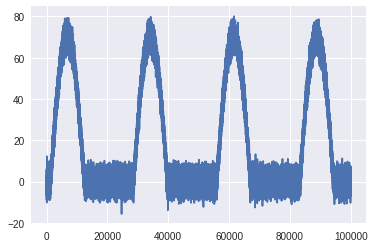

In [26]:
plt.plot(waveform)

In [27]:
t_device = cuda.to_device(t)
noise_device = cuda.to_device(noise)
pulses_device = cuda.device_array(shape=(n,), dtype=np.float32)
waveform_device = cuda.device_array(shape=(n,), dtype=np.float32)
%timeit make_pulses(t_device, period, 100.0, out=pulses_device)
%timeit add_ufunc(pulses_device, noise_device, out=waveform_device)
waveform = waveform_device.copy_to_host()

1000 loops, best of 3: 1.84 ms per loop
1000 loops, best of 3: 842 µs per loop


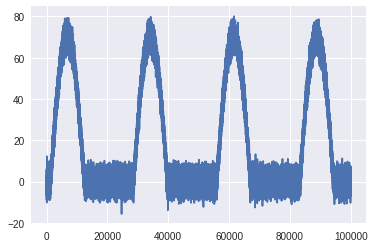

In [28]:
plt.plot(waveform)

### Problem 3 - Writing Cuda Kernels

While targeting ufuncs with the `cuda` syntax is the most straightforward way to access the GPU with Numba, it may not be flexible enough for your needs. If you want to write a more detailed GPU program, at some point you are probably going to need to write CUDA kernels.

As discussed in the lecture, the CUDA programming model allows you to abstract the GPU hardware into a software model composed of a **grid** containing **blocks** of **threads**. These threads are the smallest individual unit in the programming model, and they execute together in groups (traditionally called **warps**, consisting of 32 thread each). Determiming the best size for your grid of thread blocks is a complicated problem that often depends on the specific algorithm and hardware you're using, but here a few good rules of thumb:
+ the size of a block should be a multiple of 32 threads, with typical block sizes between 128 and 512 threads per block.
+ the size of the grid should ensure the full GPU is utilized where possible. Launching a grid where the number of blocks is 2x-4x the number of "multiprocessors" on the GPU is a good starting place. Something in the range of 20 - 100 blocks is usually a good starting point.
+ The CUDA kernel launch overhead does depend on the number of blocks, so it may not be best to launch a grid where the number of threads equals the number of input elements when the input size is very big. We'll show a pattern for dealing with large inputs below.

As a first example, let's return to our vector addition function, but this time, we'll target it with the `cuda.jit` decorator:

In [0]:
@cuda.jit
def add_kernel(x, y, out):
    tidx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    bidx = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_dimx = cuda.blockDim.x  # number of threads per block
    grid_dimx = cuda.gridDim.x    # number of blocks in the grid
    
    start = tidx + bidx * block_dimx
    stride = block_dimx * grid_dimx

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]


That's a lot more typing than our ufunc example, and it is much more limited: it only works on 1D arrays, it doesn't verify input sizes match, etc. Most of the function is spent figuring out how to turn the block and grid indices and dimensions into unique offsets in the input arrays. The pattern of computing a starting index and a stride is a common way to ensure that your grid size is independent of the input size. The striding will maximize bandwidth by ensuring that threads with consecuitive indices are accessing consecutive memory locations as much as possible. Thread indices beyond the length of the input (x.shape[0], since x is a NumPy array) automatically skip over the for loop.

Let's call the function now on some data:

In [32]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


The calling syntax is designed to mimic the way CUDA kernels are launched in C, where the number of blocks per grid and threads per block are specified in the square brackets, and the arguments to the function are specified afterwards in parentheses.

Note that, unlike the ufunc, the arguments are passed to the kernel as full NumPy arrays. A thread within the kernel can access any element in the array it wants, regardless of its position in the thread grid. This is why CUDA kernels are significantly more powerful than ufuncs. (But with great power, comes a greater amount of typing...)

Numba has created some [helper functions](http://numba.pydata.org/numba-doc/dev/cuda/kernels.html#absolute-positions) to cut down on the typing. We can write the previous kernel much more simply as:

In [0]:
@cuda.jit
def add_kernel(x, y, out):
    start = cuda.grid(1)      # the 1 argument means a one dimensional thread grid, this returns a single value
    stride = cuda.gridsize(1) # ditto

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

As before, using NumPy arrays forces Numba to allocate GPU memory, copy the arguments to the GPU, run the kernel, then copy the argument arrays back to the host. This not very efficient, so you will often want to allocate device arrays.

**3a)** Allocate device arrays for x, y, and the output, then try out your new Cuda kernel using the pre-copied device arrays. Compare the time to a version without moving the data first.

In [0]:
# add code here
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)
out_device = cuda.device_array_like(x)

In [35]:
# add code here
%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)

The slowest run took 104.57 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 1.92 ms per loop


In [36]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); out = out_device.copy_to_host()

The slowest run took 382.86 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 560 µs per loop


#### Atomic Operations and avoiding Race Conditions

CUDA, like many general purpose parallel execution frameworks, makes it possible to have race conditions in your code. A race condition in CUDA arises when threads read or write a memory location that might be modified by another independent thread. Generally speaking, you need to worry about:
+ read-after-write hazards: One thread is reading a memory location at the same time another thread might be writing to it.
+ write-after-write hazards: Two threads are writing to the same memory location, and only one write will be visible when the kernel is complete.

A common strategy to avoid both of these hazards is to organize your CUDA kernel algorithm such that each thread has exclusive responsibility for unique subsets of output array elements, and/or to never use the same array for both input and output in a single kernel call. (Iterative algorithms can use a double-buffering strategy if needed, and switch input and output arrays on each iteration.)
However, there are many cases where different threads need to combine results. Consider something very simple, like: "every thread increments a global counter." Implementing this in your kernel requires each thread to:
1. Read the current value of a global counter.
2. Compute counter + 1.
3. Write that value back to global memory.
However, there is no guarantee that another thread has not changed the global counter between steps 1 and 3. To resolve this problem, CUDA provides "atomic operations" which will read, modify and update a memory location in one, indivisible step. Numba supports several of these functions, [described here](http://numba.pydata.org/numba-doc/dev/cuda/intrinsics.html#supported-atomic-operations).

As an example, let's make a thread counter kernel:

In [0]:
@cuda.jit
def thread_counter_race_condition(global_counter):
    global_counter[0] += 1  # This is bad
    
@cuda.jit
def thread_counter_safe(global_counter):
    cuda.atomic.add(global_counter, 0, 1)  # Safely add 1 to offset 0 in global_counter array

In [38]:
# This gets the wrong answer
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_race_condition[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

Should be 4096: [1]


In [39]:
# This works correctly
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_safe[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

Should be 4096: [4096]


**3b)** Let's practice writing a function that requires an atomic operation - a histogramming kernel. This will take an array of input data, a range and a number of bins, and count how many of the input data elements land in each bin. Below is an example CPU implementation of histogramming:

In [0]:
def cpu_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    # Note that we don't have to pass in nbins explicitly, because the size of histogram_out determines it
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    # This is a very slow way to do this with NumPy, but looks similar to what you will do on the GPU
    for element in x:
        bin_number = np.int32((element - xmin)/bin_width)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            # only increment if in range
            histogram_out[bin_number] += 1

In [41]:
x = np.random.normal(size=10000, loc=0, scale=1).astype(np.float32)
xmin = np.float32(-4.0)
xmax = np.float32(4.0)
histogram_out = np.zeros(shape=10, dtype=np.int32)

cpu_histogram(x, xmin, xmax, histogram_out)

histogram_out

array([   5,   72,  496, 1557, 2908, 2787, 1579,  513,   74,    9],
      dtype=int32)

In the space below, create a cuda version of this kernel, then run it to check that you get the same answer as the CPU version.

*You can use much of the same syntax that we used in the cuda addition kernel.*

In [0]:
@cuda.jit
def cuda_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    
    # add code here
    
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    for i in range(start, x.shape[0], stride):
      bin_number = np.int32((x[i] - xmin)/bin_width)
      if bin_number >= 0 and bin_number < histogram_out.shape[0]:
        cuda.atomic.add(histogram_out, bin_number, 1)

In [43]:
threads_per_block = 128
blocks_per_grid = 30
histogram_out = np.zeros(shape=10, dtype=np.int32)
cuda_histogram[blocks_per_grid, threads_per_block](x, xmin, xmax, histogram_out)

histogram_out

array([   5,   72,  496, 1557, 2908, 2787, 1579,  513,   74,    9],
      dtype=int32)

### Problem 4 - Return to the Fractals!

Yesterday we defined two functions to create an instance of the Julia set:

In [0]:
def julia(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Julia
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(-0.8, 0.156)
    a = complex(x,y)
    for i in range(max_iters):
        a = a*a + c
        if (a.real*a.real + a.imag*a.imag) > 1000:
            return 0
    return 255

In [0]:
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = julia(real, imag, iters)
            image[y, x] = color

    return image

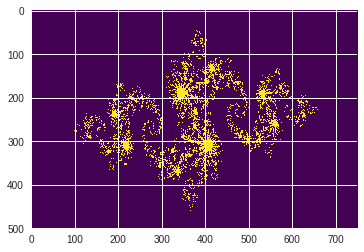

In [46]:
image = np.zeros((500, 750), dtype=np.uint8)
create_fractal(-2.0, 2.0, -1.0, 1.0, image, 200)
plt.imshow(image)
plt.viridis()
plt.show()

In order to turn this into a GPU implementation, we'd like to have a kernel function (create_fractal) call another function (julia) on the device. Numba has a way of specifying functions that will be called from within a kernel by passing the `cuda.jit` decorator an argument:

In [0]:
@cuda.jit(device=True)
def julia(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Julia
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(-0.8, 0.156)
    a = complex(x,y)
    for i in range(max_iters):
        a = a*a + c
        if (a.real*a.real + a.imag*a.imag) > 1000:
            return 0
    return 255

**Multi-dimensional grids**

For some problems, it makes sense to define a two- or three-dimensional grid of thread blocks. That way, when you're indexing a single thread, you can map it to, say, the pixel position in an image. Multi-dimensional grids are created by passing tuples to the kernel function. You can ensure that you launch a big enough grid by calculating the size of each dimension as a function of the array size and number of threads per block:

In [0]:
threadsperblock = 16
xblocks = (image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (image.shape[0] + (threadsperblock - 1)) // threadsperblock

Then, within a kernel, you can determine the absolute thread position by calling the `grid` helper function, as in `x, y = cuda.grid(2)`.

**4a)** Modify the create_fractal function to launch as a kernel on the GPU and call your new device function, julia. Use a 2D grid of thread blocks to launch the kernel and determine which threads are responsible for each pixel in the image.

In [0]:
@cuda.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    x, y = cuda.grid(2)
    
    if x < width and y < height:
      real = min_x + x * pixel_size_x
      imag = min_y + y * pixel_size_y
      color = julia(real, imag, iters)
      image[y, x] = color

In [0]:
image = np.zeros((500, 750), dtype=np.uint8)
threadsperblock = 16
threads_per_block = (16, 16)
xblocks = (image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (image.shape[0] + (threadsperblock - 1)) // threadsperblock
blocks_per_grid = (xblocks, yblocks)

The slowest run took 227.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 1.37 ms per loop


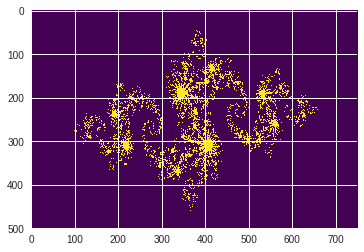

In [51]:
%timeit create_fractal[blocks_per_grid, threads_per_block](-2.0, 2.0, -1.0, 1.0, image, 200)
plt.imshow(image)
plt.viridis()
plt.show()

**4b)** How does the GPU implementation compare to the CPU version? How about to yesterday's Numba CPU version?

Yesterday I got a time of over 3 seconds for the original CPU version, ~50 ms for the pre-compiled Numba version, and 1.37 ms for the Numba GPU version!